<a href="https://colab.research.google.com/github/Michael-Jimenez-C/CieCom2/blob/main/MapaCII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import folium
import numpy as np

In [3]:
m=folium.Map(location=[4.61,-74.082], zoom_start=10)

puntos={"Bogota":[4.61,-74.082],
        "Soacha":[4.583,-74.217],
        "Madrid":[4.733,-74.267],
        "Facatativa":[4.817,-74.367],
        "Fusagasuga":[4.333,-74.35],
        "Funza":[4.717,-74.217],
        "Chia":[4.85,-74.05],
        "Zipaquira":[5.02836,-73.9992],
        "Girardot":[4.3,-74.8],
        "Villeta":[5.017,-74.467],
        "Macheta":[5.07983,-73.6072],
        "La Vega":[4.99946,-74.3399],
        "Tocaima":[4.45903,-74.634],
        "Mosquera":[4.70612,-74.2307],
        "La Mesa":[4.633,-74.467],
        "Cota":[4.817,-74.1],
        "Gachancipa":[4.99228,-73.8712],
        "La calera":[4.717,-73.967],
        "Choachi":[4.52748,-73.9257],
        "Chipaque":[4.44294,-74.0445]}

In [4]:
c=lambda a: 2*np.arctan2(pow(a,1/2),pow(1-a,1/2))
a=lambda lat1,long1,lat2,long2: pow(np.sin((lat2-lat1)/2),2)+np.cos(lat1)*np.cos(lat2)*pow(np.sin((long2-long1)/2),2)
d=lambda A,B: 6378E1*c(a(A[0],A[1],B[0],B[1]))

In [5]:
class Nodo:
  def __init__(self,nombre,coordenadas):
    self.nombre=nombre
    self.coordenadas=coordenadas
    self.conexiones=[]
    self.status=0#0 no visitado, 1 visitado, 2 pendiente
  
  
  def conectar(self,other):
    d=lambda A,B: pow(pow(A[0]-B[0],2)+pow(A[1]-B[1],2),1/2)
    if other not in self.conexiones:
      self.conexiones.append((other,d(self.coordenadas,other.coordenadas)))
    if self not in other.conexiones:
      other.conexiones.append((self,d(self.coordenadas,other.coordenadas)))
      
  def clonar(self):
    return 
  '''
  def distancia(self,nombreNodo):
    for i in self.conexiones:
      if i[0].nombre==nombreNodo:
        return  [i[0],i[1]]
    distancia=np.infty
    d=[]
    for i in self.conexiones:
      if i[0].status==1:
        continue
      self.status=1
      k=i[0].distancia(nombreNodo)
      if k!=None:
        print(k[1])
        distancia=np.minimum(distancia,i[1]+k[1])
        d=[i[0]]
        d.extend(k)
    self.status=0
    return [d,distancia]
  '''

  def dijkstra(self):
    pass
  def __repr__(self):
    return self.nombre

In [6]:
A=Nodo("A",(0,1))
B=Nodo("B",(1,2))
C=Nodo("C",(2,1))
D=Nodo("D",(3,3))
E=Nodo("E",(3,2))
F=Nodo("F",(4,0))
G=Nodo("G",(4,2))
H=Nodo("H",(4,3))

In [16]:
A.conectar(B)
A.conectar(C)
B.conectar(D)
B.conectar(E)
B.conectar(C)
C.conectar(F)
C.conectar(G)
D.conectar(H)
E.conectar(G)
G.conectar(H)

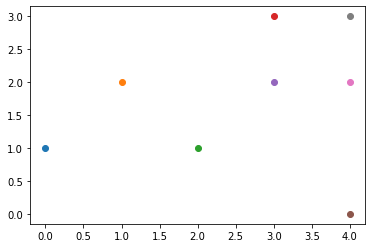

In [15]:
import matplotlib.pyplot as plt
for i in [A,B,C,D,E,F,G,H]:
  plt.scatter(i.coordenadas[0],i.coordenadas[1])

In [17]:
A.distancia("H")

1.0
1.0
1.0
2.0
inf
1.0
inf
1.0
3.23606797749979
1.0
1.0
1.0
2.0
inf
1.0
inf
1.0
3.23606797749979
3.23606797749979
1.0
inf
1.0
inf
1.0
3.23606797749979
1.0
inf
1.0
inf
1.0
3.23606797749979
3.23606797749979
1.0
1.0
inf
1.0
inf
1.0
3.23606797749979
1.0
inf
1.0
inf
1.0
3.23606797749979
3.23606797749979
1.0
2.0
1.0
1.0
1.0
2.0
inf
1.0
inf
1.0
3.23606797749979
1.0
1.0
1.0
2.0
inf
1.0
inf
1.0
3.23606797749979
3.23606797749979
1.0
1.0
1.0
2.0
1.0
1.0
1.0
2.0
3.23606797749979
inf
1.0
1.0
1.0
1.0
2.0
1.0
1.0
1.0
2.0
3.23606797749979
inf
1.0
3.23606797749979


[[C, [G, H, 1.0], 3.23606797749979], 4.650281539872885]

In [ ]:
for i in puntos:
  folium.Marker(
      puntos[i], popup=f"<i>{i}</i>"
  ).add_to(m)
m